# Notebook to read a dataset and do basic field statistics and distributions

Notebook for first interaction with a new data set. We can run it once, then start making modifications for the particular data set.

We get first look at the data with this notebook and then decide to switch some field types between how they are automatically selected as either numeric or categorical. We use the lists switch_n2c and switch_c2n for this, then run it again to get updated statistics tables. We can put the datetime fields as numeric for now but later on decide if they'd be better as categorical.

It's fine to use the automated simple distribution plots over all the fields, but for a proper examination field by field and for a Data Quality Report we make individual plots for each field with appropriate ranges and lin/log y scale choices for each field.

For a supervised predictive model then there's a cell that will plot field populations along with the overall average of the dependent variable field, if we can identify an approprite y at this point.

There's also two placeholder cells at the bottom that will plot a distribution for either a categorical or numeric field which can be used and copied as needed for fields where we want to make plots for a DQR, primarily adjusting the x range and the y scale, log or linear.

In [1]:
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
start_time = dt.datetime.now()
print('LOAD DURATION: ', dt.datetime.now() - start_time)

LOAD DURATION:  0:00:00.000046


In [2]:
%%time
data = pd.read_csv('applications data.csv')
# data = pd.read_json('transactions.txt', lines=True)

CPU times: user 1.34 s, sys: 228 ms, total: 1.57 s
Wall time: 1.69 s


In [3]:
print('data.shape=',data.shape)
data.dropna(how='all', axis=1, inplace=True) # drop any empty columns
print('data.shape=',data.shape)
print(data.info())

data.shape= (1000000, 10)
data.shape= (1000000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   record       1000000 non-null  int64 
 1   date         1000000 non-null  int64 
 2   ssn          1000000 non-null  int64 
 3   firstname    1000000 non-null  object
 4   lastname     1000000 non-null  object
 5   address      1000000 non-null  object
 6   zip5         1000000 non-null  int64 
 7   dob          1000000 non-null  int64 
 8   homephone    1000000 non-null  int64 
 9   fraud_label  1000000 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 76.3+ MB
None


In [4]:
data.tail().transpose()

,999995,999996,999997,999998,999999
record,999996,999997,999998,999999,1000000
date,20171231,20171231,20171231,20171231,20171231
ssn,766104848,445178058,25283410,361232148,40027083
firstname,XUSAAURMZ,SAAJJEMTX,ESRXXRSUX,XXMZSRXMA,RXZXSMEZA
lastname,EJXXEXZX,UMAUETJX,EUEJRJJE,RSRSUJSS,UTEAAZXU
address,8079 EJRUJ AVE,4817 UMSXT AVE,7562 RJMAZ ST,3408 UZZAM WY,112 UTTJT PL
zip5,54890,74683,86805,49183,39491
dob,19550418,19150624,19880628,20120302,19820826
homephone,8236558223,6790134432,3997657622,5935293731,5869926905
fraud_label,0,0,0,0,0


In [5]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

print(mem_usage(data))

244.69 MB


In [6]:
# add a dummy categorical column for the case the fields all look numeric. This helps build the stats tables.
data['dummy'] = 'temp'

In [7]:
df_stats = pd.DataFrame(data.count(),columns=['count'])
df_stats['isna'] = data.isna().sum()
df_stats['% pop'] = 1 - data.isna().sum()/len(data)
df_stats

,count,isna,% pop
record,1000000,0,1.0
date,1000000,0,1.0
ssn,1000000,0,1.0
firstname,1000000,0,1.0
lastname,1000000,0,1.0
address,1000000,0,1.0
zip5,1000000,0,1.0
dob,1000000,0,1.0
homephone,1000000,0,1.0
fraud_label,1000000,0,1.0


In [8]:
data.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
record,1000000.0,NaN,NaN,NaN,500000.5,288675.278932,1.0,250000.75,500000.5,750000.25,1000000.0
date,1000000.0,NaN,NaN,NaN,20170667.778959,344.986943,20170101.0,20170402.0,20170702.0,20171001.0,20171231.0
ssn,1000000.0,NaN,NaN,NaN,508341536.808841,293486376.963243,36.0,254217569.5,508814417.5,763092366.0,999999999.0
firstname,1000000,78136,EAMSTRMT,12658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lastname,1000000,177001,ERJSAXA,8580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
address,1000000,828774,123 MAIN ST,1079,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zip5,1000000.0,NaN,NaN,NaN,50073.333143,28915.921546,2.0,24992.0,50492.0,74496.0,99999.0
dob,1000000.0,NaN,NaN,NaN,19517248.662061,356887.199656,19000101.0,19160922.0,19500901.0,19830316.0,20161031.0
homephone,1000000.0,NaN,NaN,NaN,5368715638.226435,3082160504.83579,593799.0,2677134300.0,5399909831.0,8109241334.0,9999999999.0
fraud_label,1000000.0,NaN,NaN,NaN,0.014393,0.119104,0.0,0.0,0.0,0.0,1.0


### Make best guess to automatically set numerics or categoricals

In [9]:
# after you run it you may want to switch some field to the other type and rerun
df = data.describe(include='all')
frac_unique = df.loc['unique']/ df.loc['count']
s1 = frac_unique.isna()
s2 = np.where(s1)[0]
s3 = np.where(s1 == False)[0]
numerics = data.columns[s2].tolist()
categoricals = data.columns[s3].tolist()

for col in data.columns:
    numunique = data[col].nunique()
    if numunique == len(data) or numunique <=6: # you can adjust this upper limit for your data set
            if col in numerics:
                numerics.remove(col)
                categoricals.extend([col])

# manually switch some if desired            
switch_n2c = ['ssn','zip5','homephone']
switch_c2n = []
numerics = [s for s in numerics if s not in switch_n2c]
categoricals = [s for s in categoricals if s not in switch_c2n]
numerics.extend(switch_c2n)
categoricals.extend(switch_n2c)
categoricals.remove('dummy')
data = data.drop(columns='dummy')
            
print('numerics:',numerics)     
print('\ncategoricals:',categoricals)     

numerics: ['date', 'dob']

categoricals: ['firstname', 'lastname', 'address', 'record', 'fraud_label', 'ssn', 'zip5', 'homephone']


In [10]:
def count_zeros(data):
    count = 0
    for i in data:
        if i == 0:
            count += 1
    return count

In [11]:
%%time
statistics_of_data1 = []
for col in numerics:
    num_zeros = count_zeros(data[col])
    percent_zeros = num_zeros / data.shape[0] * 100
    statistics_of_data1.append((col,
                             'numeric',
                             data[col].notnull().sum(),
                             f'{data[col].notnull().sum()/data.shape[0]*100:.2f}%',
#                              f'{percent_zeros:.2f}%',  # convert to percentage with 2 decimal places
                             count_zeros(data[col]),
                             round(data[col].min(), 2),
                             round(data[col].max(), 2),
                             data[col].mean(),
                             round(np.std(data[col]), 2),
                             data[col].mode()[0]
                             ))

stats_dfnum = pd.DataFrame(statistics_of_data1, columns = ['Field Name', 'Field Type','# Records Have Values', '% Populated', '# Zeros', 'Min', 'Max', 'Mean', 'Standard Deviation', 'Most Common'])
#stats_dfnum.to_excel('numerics table.xlsx',index=False)
stats_dfnum

CPU times: user 454 ms, sys: 15.1 ms, total: 469 ms
Wall time: 476 ms


,Field Name,Field Type,# Records Have Values,% Populated,# Zeros,Min,Max,Mean,Standard Deviation,Most Common
0,date,numeric,1000000,100.00%,0,20170101,20171231,2.017067e+07,344.99,20170816
1,dob,numeric,1000000,100.00%,0,19000101,20161031,1.951725e+07,356887.02,19070626


In [12]:
%%time
statistics_of_data = []
for col in categoricals:
    statistics_of_data.append((col,
                             'categorical',
                             data[col].notnull().sum(),
                             f'{data[col].notnull().sum()/data.shape[0]*100:.2f}%',
                             count_zeros(data[col]),
                             data[col].nunique(),
                             data[col].mode()[0]
                            
                             ))
stats_dfcat = pd.DataFrame(statistics_of_data, columns = ['Field Name', 'Field Type','# Records Have Values', '% Populated', '# Zeros','# Unique Values', 'Most Common',])
#stats_dfcat.to_excel('categoricals table.xlsx',index=False)
stats_dfcat

CPU times: user 2.8 s, sys: 219 ms, total: 3.01 s
Wall time: 3.43 s


,Field Name,Field Type,# Records Have Values,% Populated,# Zeros,# Unique Values,Most Common
0,firstname,categorical,1000000,100.00%,0,78136,EAMSTRMT
1,lastname,categorical,1000000,100.00%,0,177001,ERJSAXA
2,address,categorical,1000000,100.00%,0,828774,123 MAIN ST
3,record,categorical,1000000,100.00%,0,1000000,1
4,fraud_label,categorical,1000000,100.00%,985607,2,0
5,ssn,categorical,1000000,100.00%,0,835819,999999999
6,zip5,categorical,1000000,100.00%,0,26370,68138
7,homephone,categorical,1000000,100.00%,0,28244,9999999999


In [19]:
# Drop any column that has only a single value (it's not a useful column)
cats_drop = []
data.drop(cats_drop, axis=1, inplace=True)
categoricals = list(set(categoricals)  - set(cats_drop))

In [13]:
%%time
def get_dup_columns(m):
    '''
    This will check every column in data frame and verify if you have duplicated columns.
    The result will be a list of tuples showing what columns are duplicates. For example: (column A, column C)
    That means that column A is duplicated with column C
    '''
    headers_list = [x for x in m.columns]
    duplicate_col2 = []
    y = 0
    while y <= len(headers_list)-1:
        for x in range(1,len(headers_list)-1):
            if m[headers_list[y]].equals(m[headers_list[x]]) == False:        
                continue
            else:
                duplicate_col2.append((headers_list[y],headers_list[x]))
        headers_list.pop(0)  
    return duplicate_col2

# You can use this cell if you want to see if any of the columns are identical
duplicate_col = get_dup_columns(data)
duplicate_col

CPU times: user 25.5 ms, sys: 2.82 ms, total: 28.3 ms
Wall time: 27.1 ms


[]

## Field Level Analysis

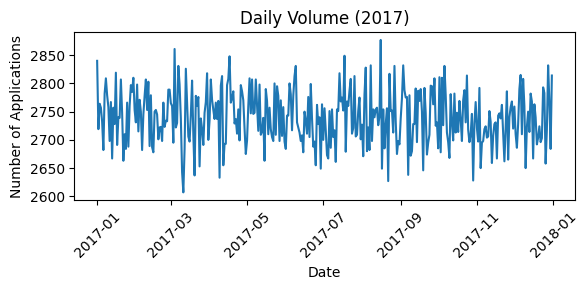

In [ ]:
df = data.copy()
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d') #convert date column to datetime type

daily_counts = df['date'].value_counts().sort_index()
plt.figure(figsize=(6,3))
plt.plot(daily_counts.index, daily_counts.values, linestyle='-', marker='')
plt.title('Daily Volume (2017)')
plt.xlabel('Date')
plt.ylabel('Number of Applications')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('apps_2017_daily.png')

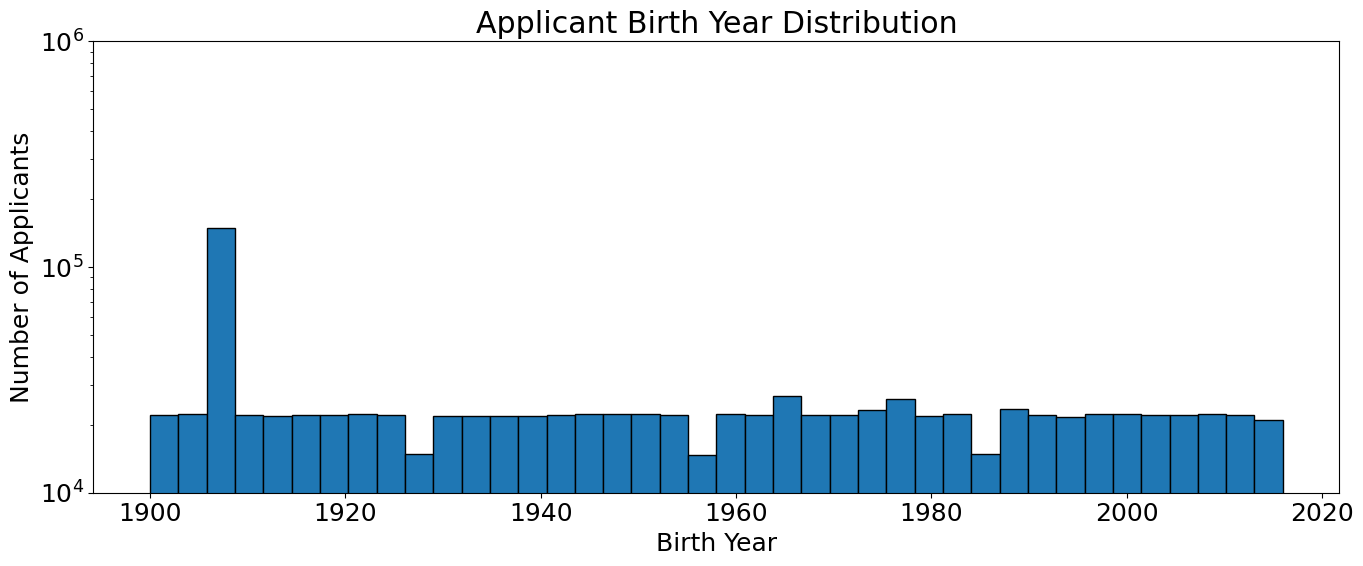

In [49]:
df['birth_year'] = pd.to_datetime(df['dob'], format='%Y%m%d').dt.year
plt.figure(figsize=(14,6))
plt.hist(df['birth_year'], bins=40, edgecolor='black')
plt.title('Applicant Birth Year Distribution')
plt.xlabel('Birth Year')
plt.ylabel('Number of Applicants')
plt.yscale('log')
plt.ylim(10000,1000000)
plt.tight_layout()
plt.savefig('dob_birthyear.png')

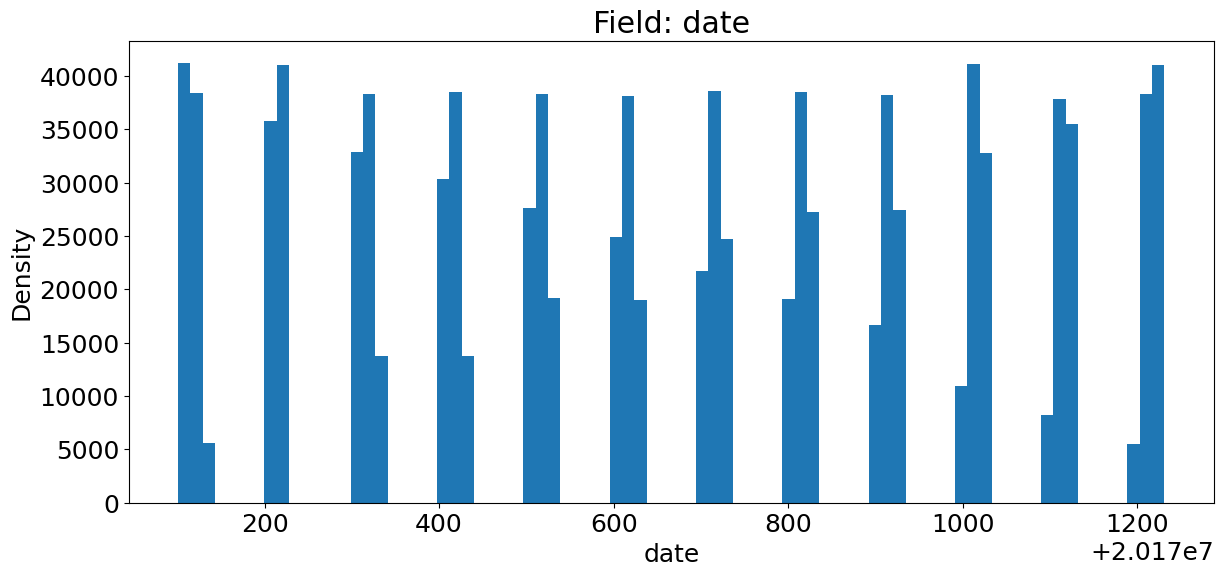

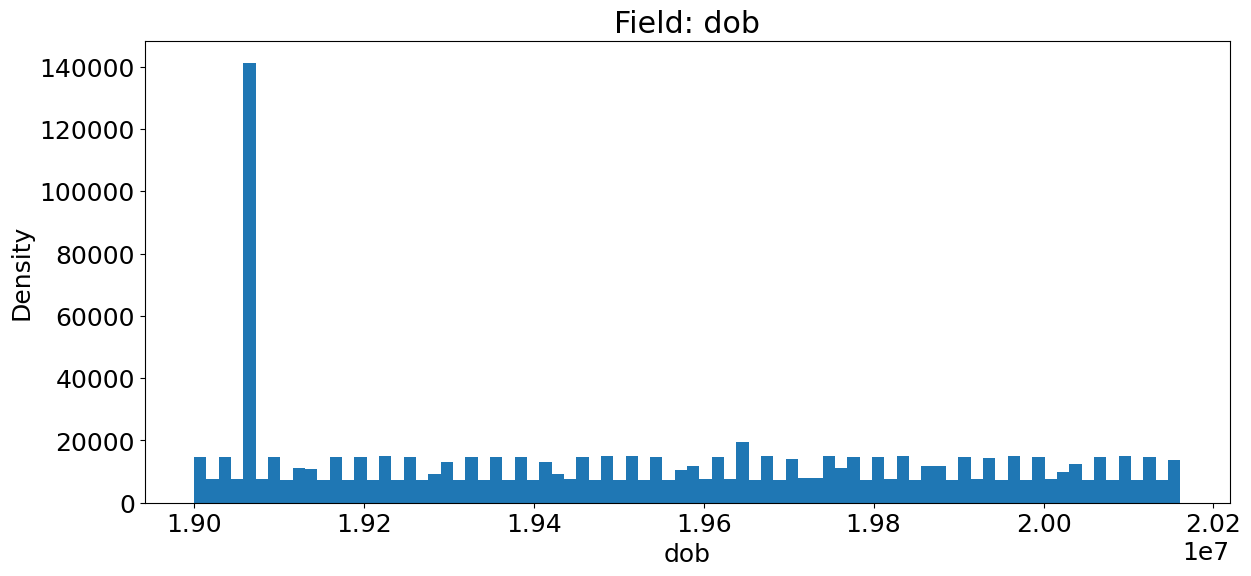

In [15]:
# plot numerics distributions if desired
plt.rcParams.update({'figure.figsize':(14,6)})
plt.rcParams.update({'font.size':18})
for col in numerics:
    plt.hist(data[col],bins=80)
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title('Field: ' + col)
    plt.show()

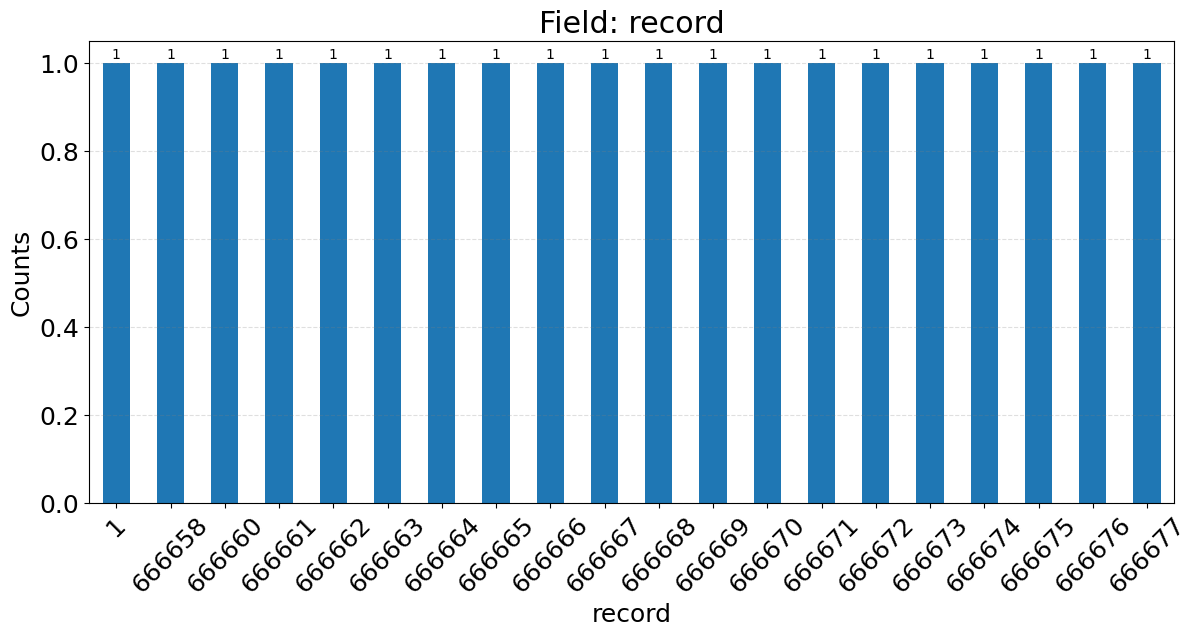

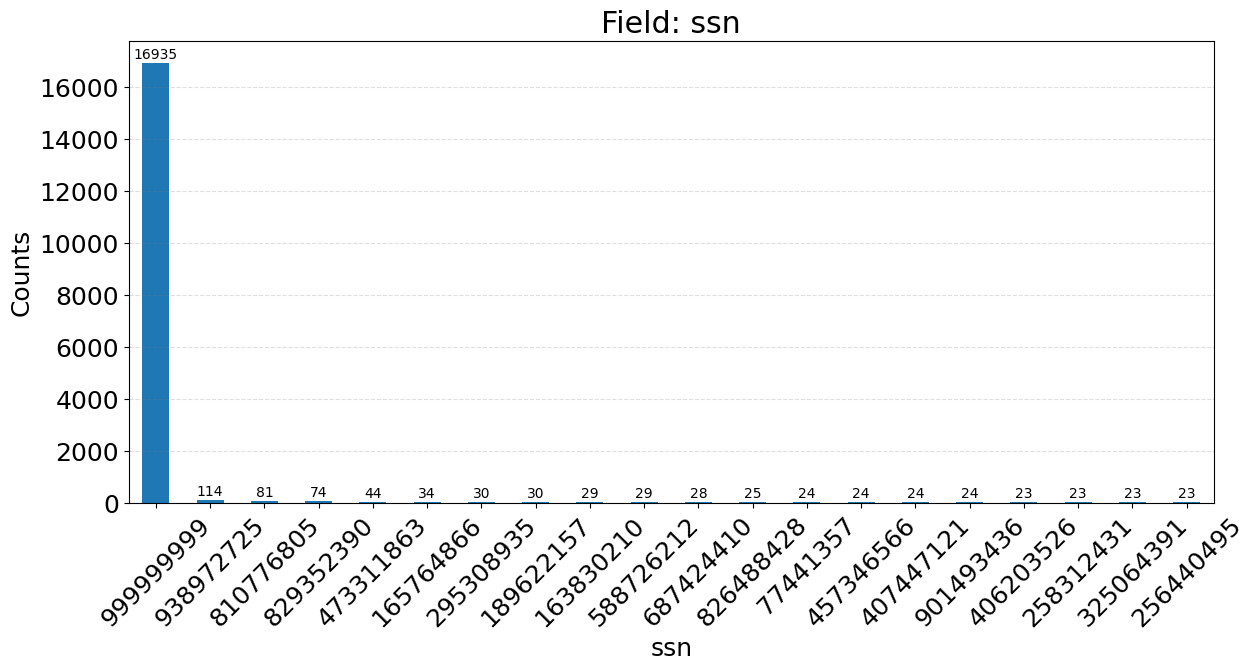

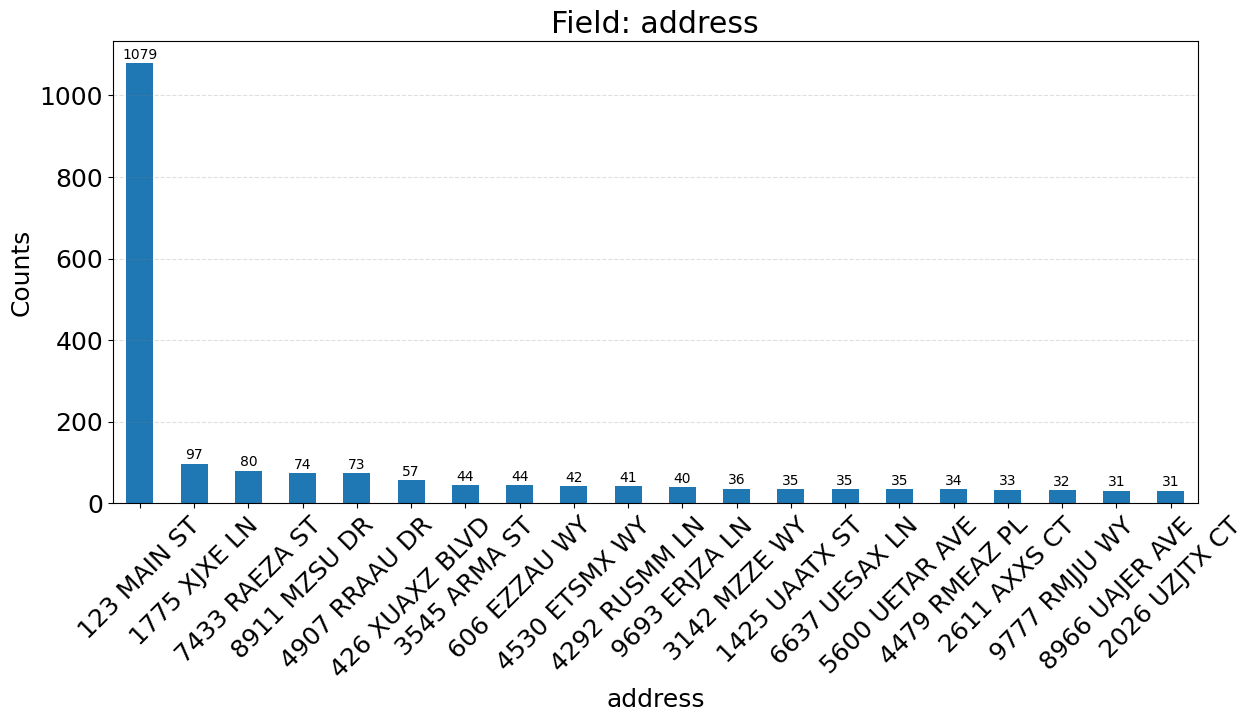

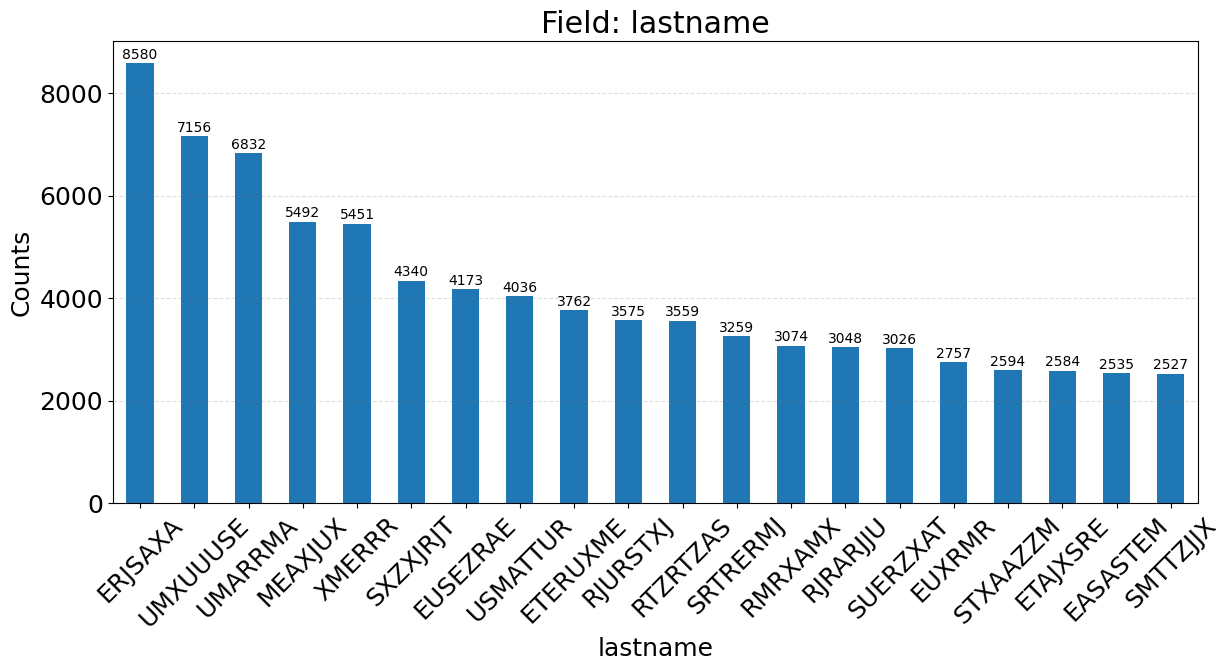

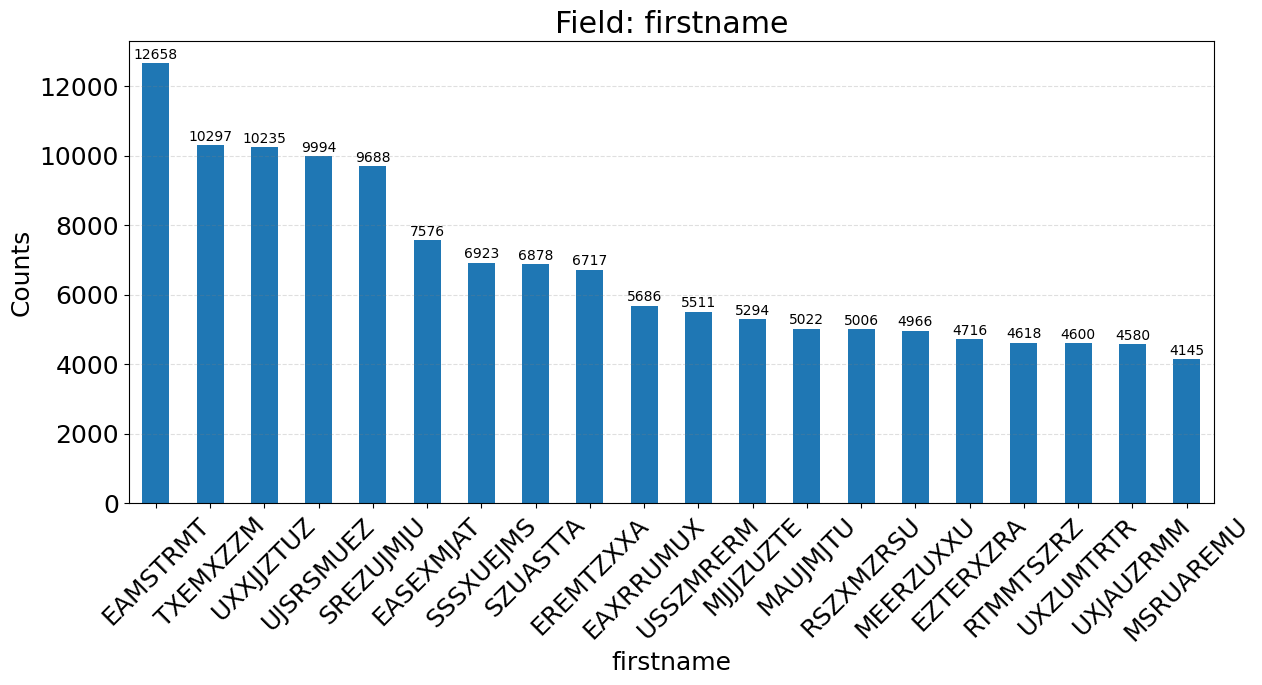

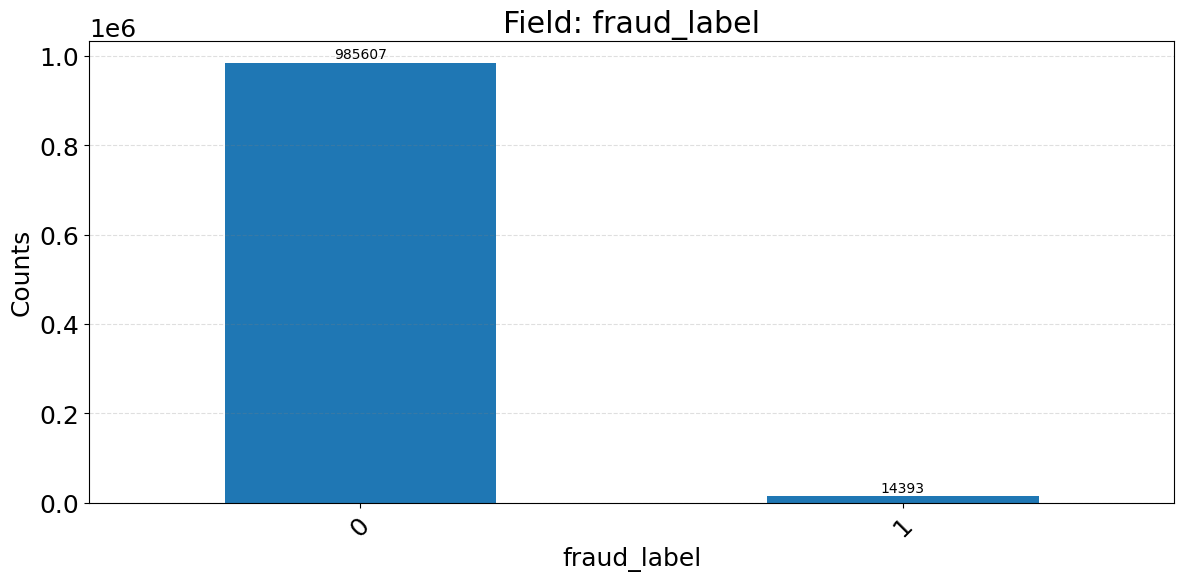

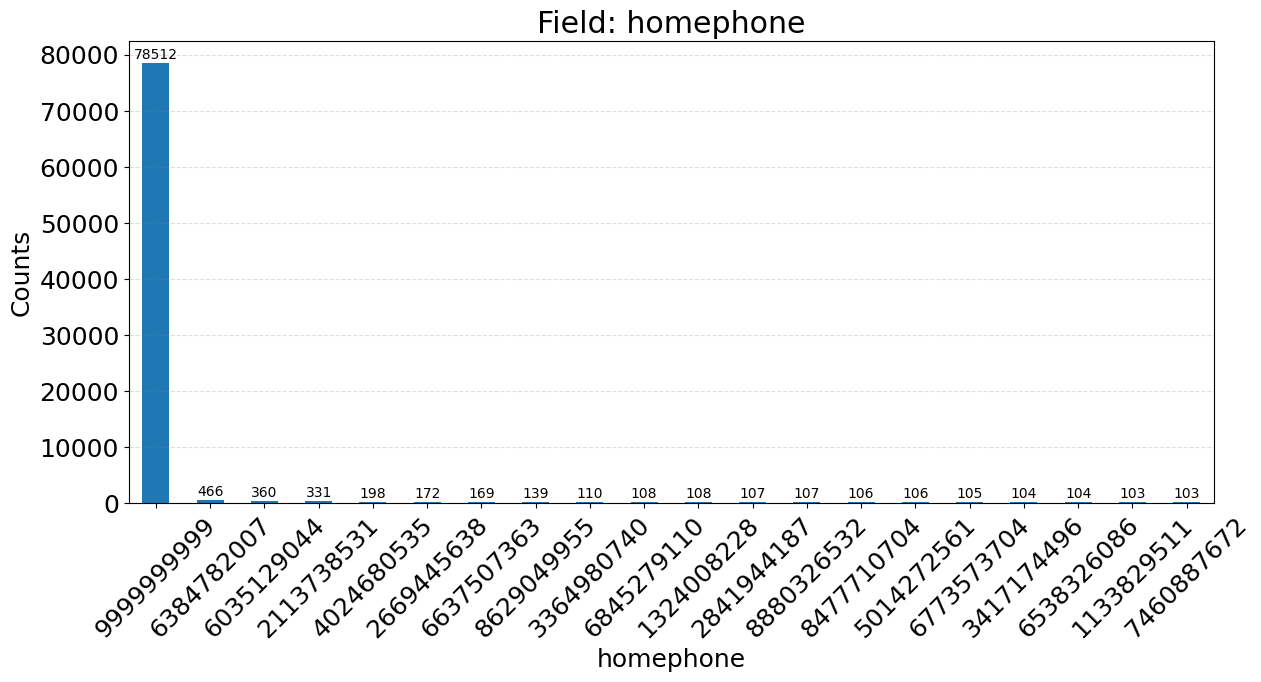

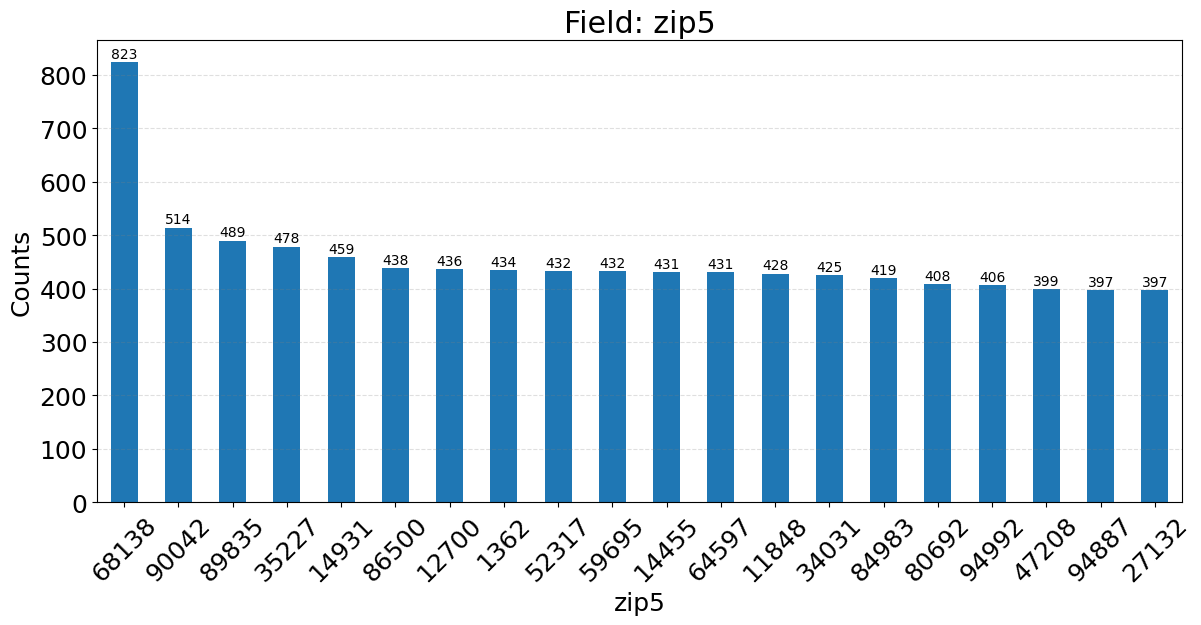

In [16]:
# plot categorical histograms if desired
for col in categoricals:
    counts = data[col].value_counts().head(20)
    ax = counts.plot(kind='bar')
    plt.xticks(rotation=45)
    for i, v in enumerate(counts):
        ax.text(i, v + counts.max()*.01, v, ha='center', color='black', fontsize=10)

    plt.title('Field: ' + col)
    plt.xlabel(col)
    plt.ylabel('Counts')
    ax.grid(True, axis='y', linestyle='--', which='major', color='grey', alpha=.25)
    plt.show()

overall dependent variable label rate is:  0.014393
1000000 different values for record


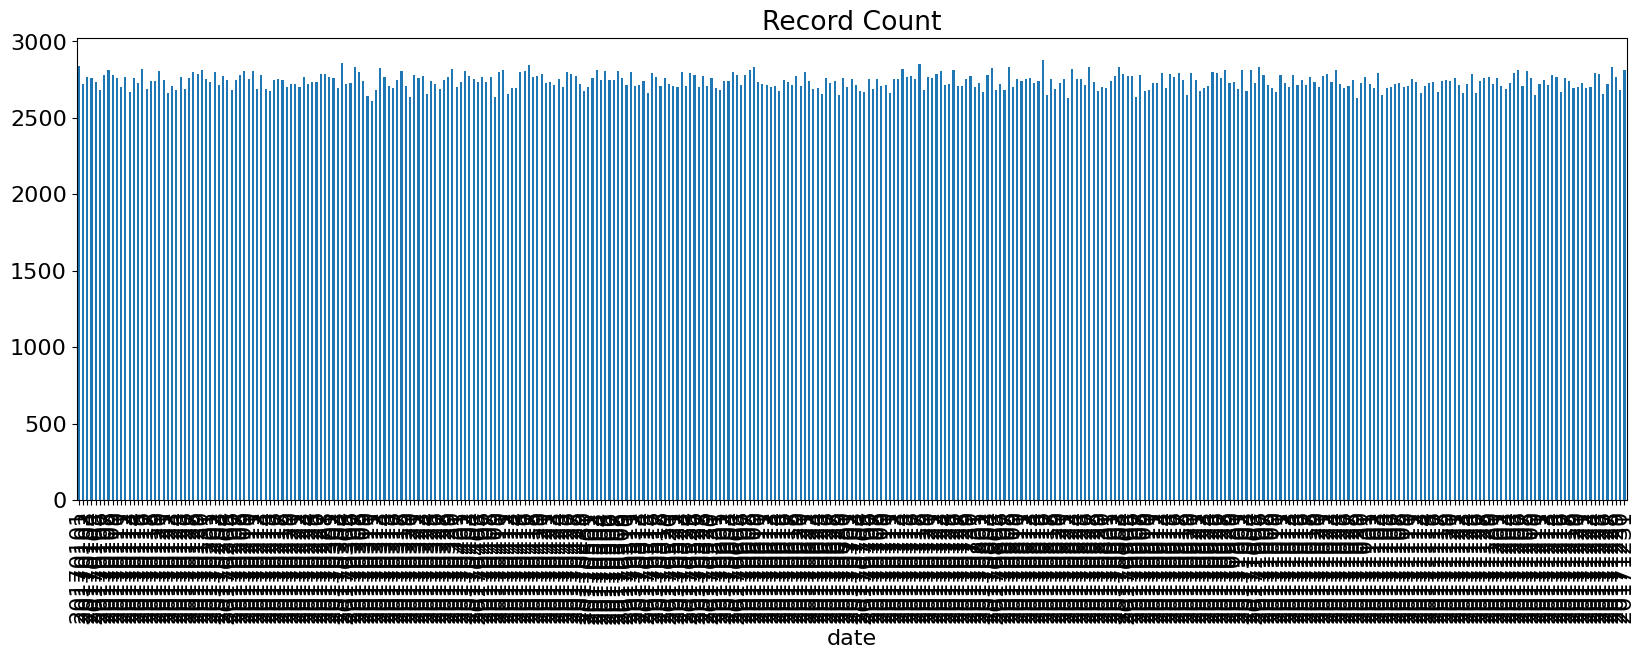

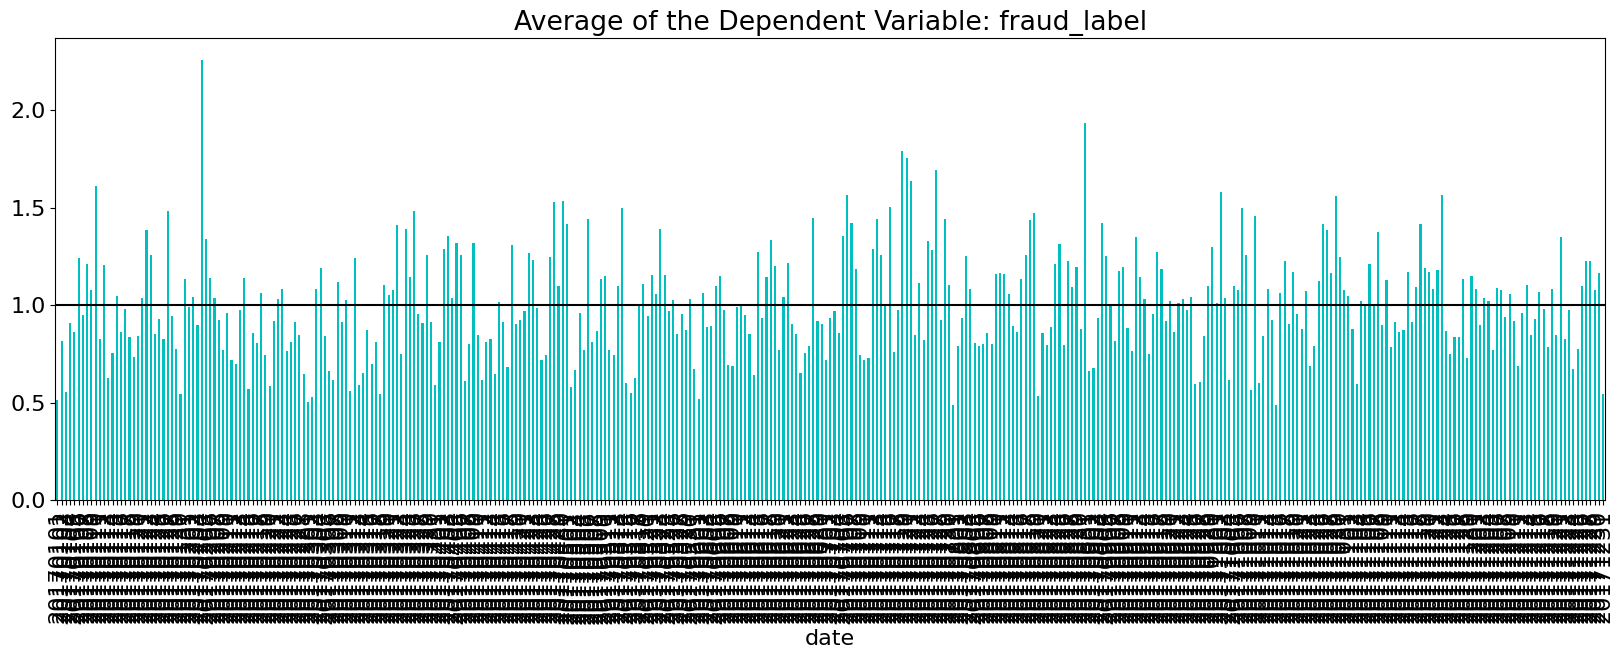

835819 different values for ssn
78136 different values for firstname
177001 different values for lastname
828774 different values for address
26370 different values for zip5
42673 different values for dob
28244 different values for homephone


In [17]:
# This cell below is for supervised problem with a dependent variable y. 
# It looks at the univariate relationship between x and y.

dep_var = 'fraud_label'

# sometimes need to convert the dependent variable to a number, particularly for a binary classification problem
# data[dep_var] = data[dep_var].map({False: 0, True: 1})
rate = data[dep_var].mean()

print('overall dependent variable label rate is: ', rate)
# Plot field distributions and compare with average of the dependent variable y (horizontal line)
plt.rcParams["figure.figsize"] = [20,6]
plt.rcParams.update({'font.size': 16})
plot_cols=data.columns.tolist()
# remove any fields you don't want to plot
# I put the range very high (370) so I could see a plot of 365 days. Usually you should set this to maybe 20 or so
plot_cols.remove(dep_var)
for col in plot_cols:
    num = data[col].nunique()
    if num > 370:
        print(num,"different values for",col)    
    else:
        plt.title('Record Count')
        plt.xlabel(col)
        data[col].value_counts().sort_index().plot(kind='bar')
        temp = data.groupby(col)[dep_var].mean() / rate
        plt.show()
        plt.xlabel(col)
        str = 'Average of the Dependent Variable: '+dep_var
        plt.title(str)
        plt.axhline(1,color='black')
        temp.plot(kind='bar',color='c')
        plt.show()

Text(0.5, 1.0, 'Field:\xa0dob')

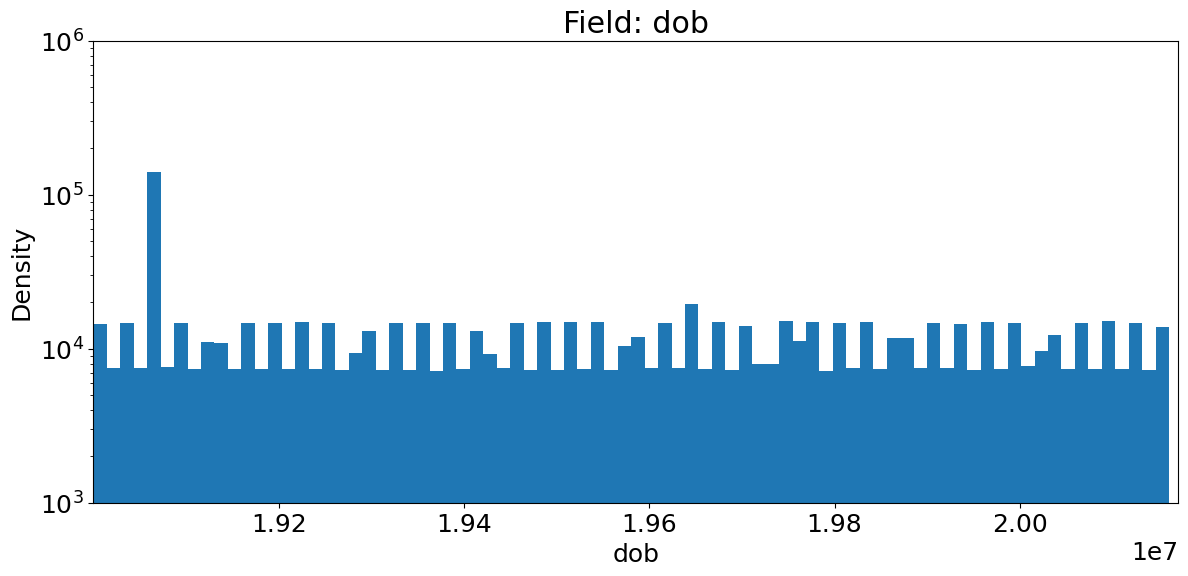

In [18]:
# Copy and use this cell as many times as needed to make customized plots for individual NUMERIC fields

plt.rcParams.update({'figure.figsize':(14,6)}) # make the plot size appropriate for the data
plt.rcParams.update({'font.size':18}) # make the font size appropriate for the plot
col = 'dob' # select a particular numeric field
# set good x range values to make a plot that shows the important info as best as possible
xlow = 19000101
xhigh = 20171231
plt.xlim(xlow,xhigh)
# let the bins span only the x range desired
temp = data[data[col]<xhigh]
temp = temp[temp[col]>xlow]
plt.yscale('log') # use log y when the y range is so large that the bins to the right are really small
plt.ylim(1000,1000000) # choose this to only show the decades needed
plt.hist(data[col], bins=80)
plt.xlabel(col)
plt.ylabel('Density')
plt.title('Field: ' + col)

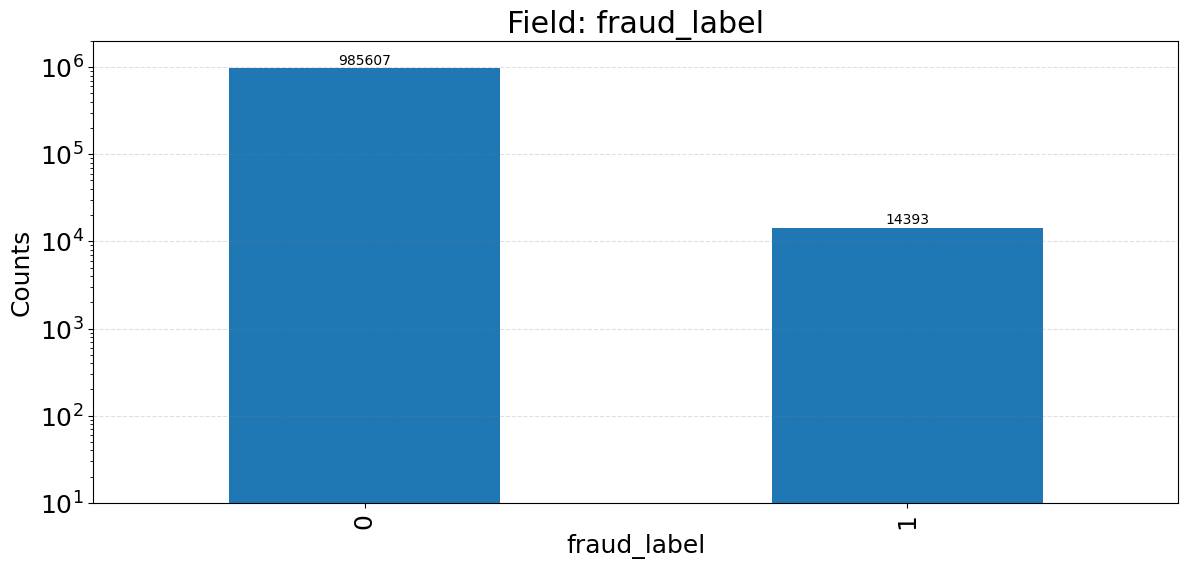

In [58]:
# Copy and use this cell as many times as needed to make customized plots for individual CATEGORICAL fields

plt.rcParams.update({'figure.figsize':(14,6)}) # make the plot size appropriate for the data
plt.rcParams.update({'font.size':18}) # make the font size appropriate for the plot
col='fraud_label' # select a particular categorical field
counts = data[col].value_counts().head(20)
ax = counts.plot(kind='bar')
plt.xticks(rotation=90) # set this to what looks best
for i, v in enumerate(counts):
#     vdelta = v + counts.max()*.01 # this works better for lin y plots
    vdelta = v*1.1 # this works better for log y plots
    ax.text(i, vdelta, v, ha='center', color='black', fontsize=10)

plt.yscale('log') # use log y when the y range is so large that the bins to the right are really small
plt.ylim(10,2000000) # choose this to only show the decades needed
plt.title('Field: ' + col)
plt.xlabel(col)
plt.ylabel('Counts')
ax.grid(True, axis='y', linestyle='--', which='major', color='grey', alpha=.25)
plt.show()

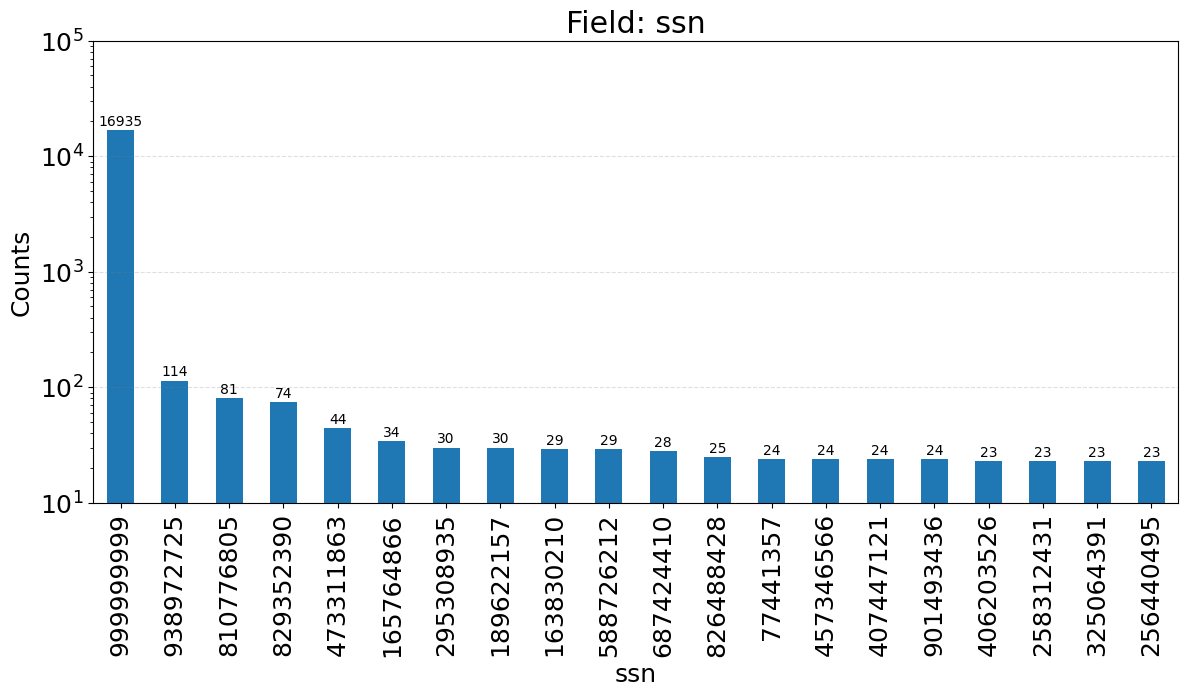

In [19]:
# Copy and use this cell as many times as needed to make customized plots for individual CATEGORICAL fields

plt.rcParams.update({'figure.figsize':(14,6)}) # make the plot size appropriate for the data
plt.rcParams.update({'font.size':18}) # make the font size appropriate for the plot
col='ssn' # select a particular categorical field
counts = data[col].value_counts().head(20)
ax = counts.plot(kind='bar')
plt.xticks(rotation=90) # set this to what looks best
for i, v in enumerate(counts):
#     vdelta = v + counts.max()*.01 # this works better for lin y plots
    vdelta = v*1.1 # this works better for log y plots
    ax.text(i, vdelta, v, ha='center', color='black', fontsize=10)

plt.yscale('log') # use log y when the y range is so large that the bins to the right are really small
plt.ylim(10,100000) # choose this to only show the decades needed
plt.title('Field: ' + col)
plt.xlabel(col)
plt.ylabel('Counts')
ax.grid(True, axis='y', linestyle='--', which='major', color='grey', alpha=.25)
plt.show()

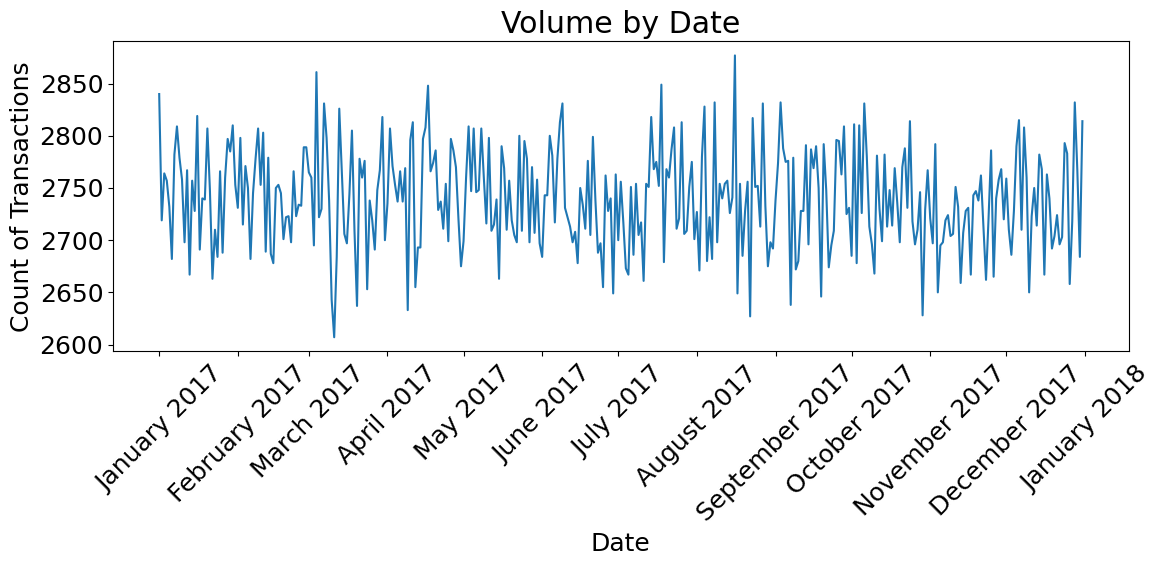

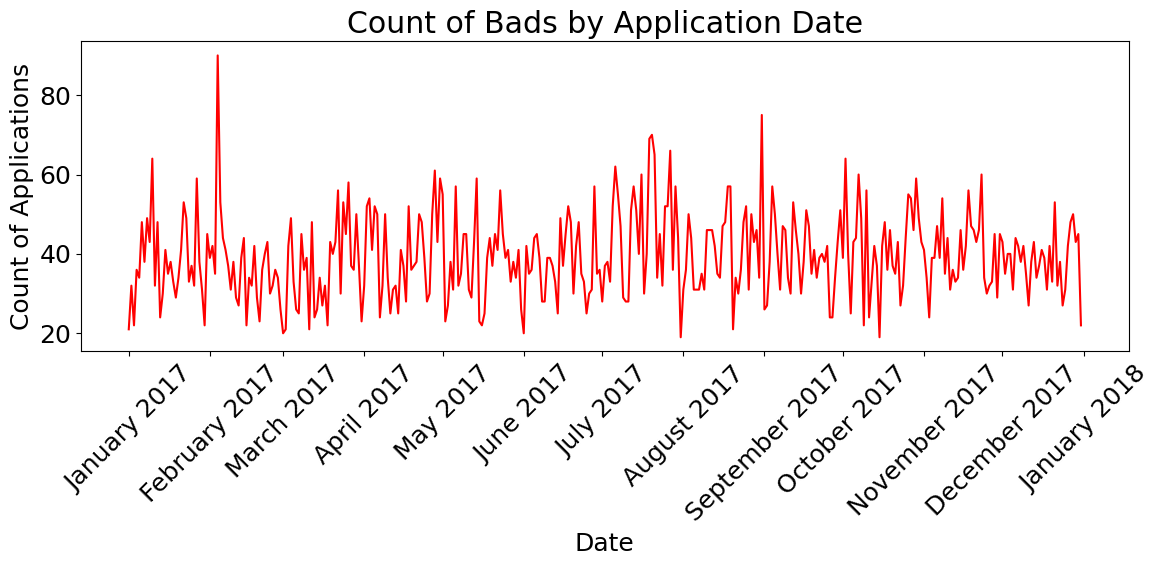

In [55]:
# If you want to make plots across time you can use this cell
# sort by time, set time as index so we can plot across time
# adjust the time scales as needed for your temp

import matplotlib.dates as mdates
time_field = 'date' # after this, do whatever you need to to make this a datetime field
temp = data.copy()
temp['appyear'] = (temp['date'] / 10000).astype('int')
temp['appmonth'] = ((temp['date'] - temp['appyear'] * 10000) / 100).astype('int')
temp['appday'] = temp['date'] - temp['appyear'] * 10000 - temp['appmonth'] * 100
temp['date'] = pd.to_datetime(temp.appyear*10000+temp.appmonth*100+temp.appday,format='%Y%m%d')
temp[time_field] = pd.to_datetime(temp[time_field]) # you may have to adjust this for your particular time field
temp.sort_values(by=[time_field],inplace=True)
temp.set_index(time_field, inplace=True)
daily_counts = temp.resample('D').size()
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(daily_counts.index, daily_counts, marker='', linestyle='-')  # Plot as a line chart
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))  # Format ticks as full month name followed by year
plt.title('Volume by Date')
plt.xlabel('Date')
plt.ylabel('Count of Transactions')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout

# If it's a binary classification problem, separate the types and plot
dep_var = 'fraud_label' # do whatever you need to do to separate the two types
# temp[dep_var] = temp[dep_var].astype(str)
# goods = temp[temp[dep_var] == 'False']
# bads = temp[temp[dep_var] == 'True']
goods = temp[temp[dep_var] == 0]
bads = temp[temp[dep_var] == 1]
daily_counts_goods = goods.resample('D').size()
daily_counts_bads = bads.resample('D').size()
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(daily_counts_bads.index, daily_counts_bads, marker='', linestyle='-', color='r')  # Plot as a line chart
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))  # Format ticks as full month name followed by year
plt.title('Count of Bads by Application Date')
plt.xlabel('Date')
plt.ylabel('Count of Applications')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability if desired
plt.tight_layout()  # Adjust the layout

In [22]:
print('duration: ', dt.datetime.now() - start_time)

duration:  0:00:08.607946
